In [12]:
%run Function_set_dic_cqm.ipynb
import networkx as nx
import numpy as np
from collections import defaultdict
import random
from numpy import random
import matplotlib.pyplot as plt

In [176]:
from collections import defaultdict

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from dwave.cloud import Client
client = Client.from_config(token='DEV-a3f87cd2fb51d10601c4e8bd16114d92614fc291')     
print(client.get_solvers() )

import networkx as nx
import numpy as np
#import dwave.inspector
import dimod
from dwave.system import LeapHybridSampler
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd

[StructuredSolver(id='DW_2000Q_6'), StructuredSolver(id='Advantage_system6.1'), StructuredSolver(id='Advantage2_prototype1.1'), StructuredSolver(id='Advantage_system4.1')]


In [177]:
network,pos = Make_Question(3,3,Density = 0.7, option = "1-norm", distance = 2)

print(network)

[[0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 0. 1. 0.]
 [1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 1. 0. 1. 0.]]


{(1, 0): '0', (2, 0): '1', (3, 0): '2', (4, 0): '3', (5, 0): '4', (6, 0): '5', (1, 3): '6', (2, 3): '7', (2, 5): '8', (3, 4): '11', (3, 6): '12', (5, 6): '15', (3, 1): '9', (3, 2): '10', (4, 3): '13', (5, 2): '14', (6, 3): '16', (6, 5): '17'}


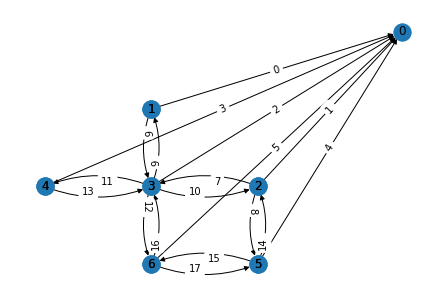

In [178]:
G, compelete_label, graph = complete_Graph(network,pos)
print(compelete_label)

In [179]:
compelete_label

{(1, 0): '0',
 (2, 0): '1',
 (3, 0): '2',
 (4, 0): '3',
 (5, 0): '4',
 (6, 0): '5',
 (1, 3): '6',
 (2, 3): '7',
 (2, 5): '8',
 (3, 4): '11',
 (3, 6): '12',
 (5, 6): '15',
 (3, 1): '9',
 (3, 2): '10',
 (4, 3): '13',
 (5, 2): '14',
 (6, 3): '16',
 (6, 5): '17'}

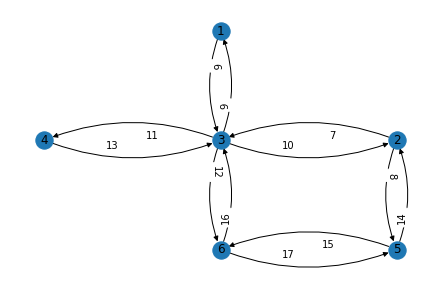

In [180]:
G_prime, sub_edge_label, sub_graph = sub_Graph (network,pos)

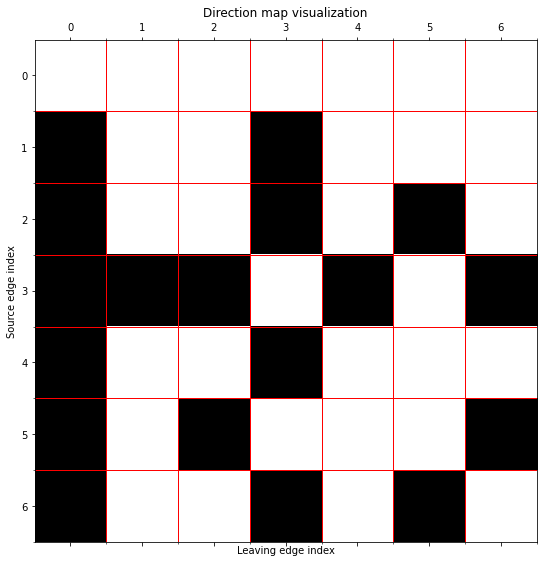

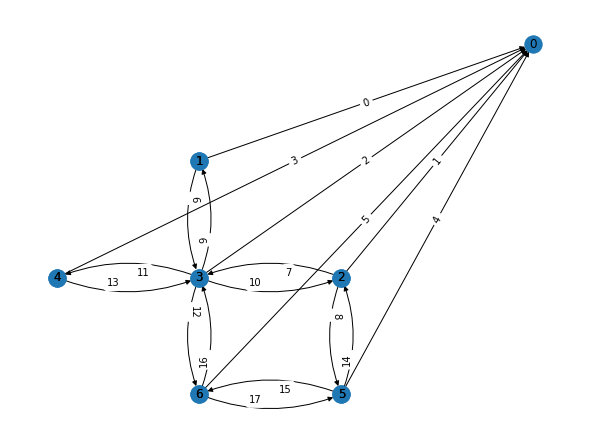

In [181]:
#matfig = plt.figure(figsize=(Final_map.shape[0],Final_map.shape[1]))
matfig = plt.figure(figsize=(9,9))
plt.matshow(network,cmap=plt.cm.binary,fignum=matfig.number)
ax = plt.gca()
#plt.matshow(Final_map,cmap=plt.cm.binary)
plt.xlabel('Leaving edge index')
plt.ylabel('Source edge index')
plt.title ("Direction map visualization")

# Major ticks
ax.set_xticks(np.arange(0, network.shape[0], step=1))
ax.set_yticks(np.arange(0, network.shape[0], step=1))

# Labels for major ticks
ax.set_xticklabels(np.arange(0, network.shape[0], step=1))
ax.set_yticklabels(np.arange(0, network.shape[0], step=1))

# Minor ticks
ax.set_xticks(np.arange(0.5, network.shape[0]+0.5, step=1), minor=True)
ax.set_yticks(np.arange(0.5, network.shape[0]+0.5, step=1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='r', linestyle='-', linewidth=1)

plt.show()


plt.figure(2,figsize=(8,6)) 
_, _, _ = complete_Graph(network,pos)

In [182]:
# How many panel ---> Max electricity level wire could reach 
Q = len(pos)-1

# How many edges
edge_number = len(compelete_label)


# basic_cost shape => (1,number_of_edge)
# such as : basic_cost = np.vstack(np.ones(number_of_edge))
# test case : #basic_cost = np.arange(edge_number)

basic_cost = np.ones(edge_number)
for i in range(Q):
    basic_cost[i] = 1 + i


# flow cost (p)
flow_cost = np.ones(edge_number) 
p = 1


# make dictionary
edge_dictionary, Total = make_dictionary(edge_number, Q, N_tree)

# initialize a QUBO matrix needed
QUBO_matrix_initial = np.zeros((Total, Total))


In [183]:
x = [[dimod.Binary(f'x_{m}_{n}') for n in range(1,Q+1)] for m in range(edge_number)]

In [184]:
#x = [[dimod.Binary(f'x_{m}_{n}') for m in range(edge_number)] for n in range(1,Q+1)]
cqm = dimod.ConstrainedQuadraticModel()
#print(edge_dictionary)

In [185]:
c_e = (np.tile(np.vstack(basic_cost),(1 , Q+1))).flatten()
        
level_coeff = (np.tile(np.arange(1,Q + 1),(edge_number,1))).flatten()
        
cqm.set_objective((sum(basic_cost[i] * sum(x[i][j] for j in range(Q)) for i in range(edge_number)) + p * sum(c_e[m] * sum(n * x[m][n] for n in range(Q)) for m in range(edge_number)) ) )

In [186]:
def constraint_1(Final_map, Q, edge_dictionary, compelete_label, vertex):
    
    index = np.hstack(np.asarray(np.where(Final_map[vertex,:])))             
            
    index_matched = []
    
    for vertex_selected in index:
        
            index_matched.append( int(compelete_label[(vertex, vertex_selected)]) )
    
    return index_matched


In [187]:
## C 1

for vertex in range(1, Q + 1):
    
    index = constraint_1(network, Q, edge_dictionary, compelete_label, vertex)
    
    #print(index)
    
    cqm.add_constraint( sum( sum(x[i][j] for j in range(Q)) for i in index) == 1, label=f'constraint_1_vertex_{vertex}')

In [188]:
def constraint_2(Final_map, Q, edge_dictionary, compelete_label, vertex):
    
    index_out = np.hstack(np.asarray(np.where(Final_map[vertex,:])))             
            
    index_out_matched = []
    
    for vertex_selected in index_out:
            
        index_out_matched.append( int(compelete_label[(vertex, vertex_selected)])  )
    
    index_in = np.hstack(np.asarray(np.where(Final_map[:,vertex])))
    
    index_in_matched = []
    
    for vertex_selected in index_in:
        index_in_matched.append( int(compelete_label[(vertex_selected, vertex )])  )

    
    return index_out_matched, index_in_matched

In [189]:
## C 2
for vertex in range(1, Q + 1):
    
    index_out, index_in = constraint_2(network, Q, edge_dictionary, compelete_label, vertex)
    
    print(index_out, index_in, level_coeff[index_in])
    
    cqm.add_constraint( sum(sum( (j+1) * x[i][j] for j in range(Q)) for i in index_out) - sum( sum( (n + 1) * x[m][n] for n in range(Q)) for m in index_in)  == 1, label=f'constraint_2_vertex_{vertex}')
    

[0, 6] [9] [4]
[1, 7, 8] [10, 14] [5 3]
[2, 9, 10, 11, 12] [6, 7, 13, 16] [1 2 2 5]
[3, 13] [11] [6]
[4, 14, 15] [8, 17] [3 6]
[5, 16, 17] [12, 15] [1 4]


In [190]:
for level in range(Q):
    if level == 2:
        cqm.add_constraint( sum(x[m][level]  for m in range(Q)) >= 1, label=f'constraint_3_left_{level}')
    else:
        cqm.add_constraint( sum(x[m][level]  for m in range(Q)) >= 0, label=f'constraint_3_left_{level}')

        cqm.add_constraint( sum(x[m][level]  for m in range(Q)) <= Q, label=f'constraint_3_right_{level}')

In [191]:
bqm, invert = dimod.cqm_to_bqm(cqm)
#sampleset = dimod.ExactSolver().sample(bqm)
from dwave.system import LeapHybridCQMSampler
sampler = LeapHybridCQMSampler(num_constraints_multiplier = 300, minimum_time_limit_s = 10, version  = '2.0')    
#print(sampler.solver.name)

c:\python38\lib\site-packages\dimod\binary\binary_quadratic_model.py:704: UserWarning: Did not add constraint 04258e9f-9e2d-4bf2-be0d-b94c3c23587d. This constraint is feasible with any value for state variables.
  warnings.warn(
c:\python38\lib\site-packages\dimod\binary\binary_quadratic_model.py:704: UserWarning: Did not add constraint 90e774a8-a53f-4a2c-a518-e32aa9315da5. This constraint is feasible with any value for state variables.
  warnings.warn(
c:\python38\lib\site-packages\dimod\binary\binary_quadratic_model.py:704: UserWarning: Did not add constraint fd88d4ae-09a8-4c56-8bd5-386f2b02b9cf. This constraint is feasible with any value for state variables.
  warnings.warn(
c:\python38\lib\site-packages\dimod\binary\binary_quadratic_model.py:704: UserWarning: Did not add constraint 1005d07e-2f84-4b52-b22e-5b7303c602a3. This constraint is feasible with any value for state variables.
  warnings.warn(
c:\python38\lib\site-packages\dimod\binary\binary_quadratic_model.py:704: UserWarnin

In [163]:
#sampleset = sampler.sample_cqm(cqm, time_limit=60, label="SDK Examples - Solar Panel Strategy")  #max time_limit=180

sampleset = sampler.sample_cqm(cqm, label="SDK Example - Solar Panel Strategy")

print(sampleset.info)

print("{} feasible solutions of {}.".format(
    sampleset.record.is_feasible.sum(), len(sampleset)))   

{'constraint_labels': ['constraint_2_vertex_4', 'constraint_1_vertex_1', 'constraint_2_vertex_5', 'constraint_3_left_1', 'constraint_1_vertex_2', 'constraint_1_vertex_4', 'constraint_3_right_4', 'constraint_1_vertex_5', 'constraint_3_right_1', 'constraint_1_vertex_3', 'constraint_3_left_2', 'constraint_3_right_3', 'constraint_2_vertex_6', 'constraint_1_vertex_6', 'constraint_2_vertex_1', 'constraint_2_vertex_3', 'constraint_3_left_4', 'constraint_3_right_0', 'constraint_2_vertex_2', 'constraint_3_right_5', 'constraint_3_left_3', 'constraint_3_left_5', 'constraint_3_left_0'], 'qpu_access_time': 15225, 'charge_time': 4940681, 'run_time': 4940681, 'problem_id': '9a2ee2ed-46ce-4483-bd1f-83ee81cb9658', 'problem_label': 'SDK Example - Solar Panel Strategy'}
3 feasible solutions of 31.


In [164]:
def parse_best(sampleset,x):
    
    best = sampleset.filter(lambda row: row.is_feasible).first
    
    x_prime = np.zeros(len(x))
        
    x_prime = [(key.replace("x_","")).split('_') for key, val in best.sample.items() if "x_" in key and val]

    return  x_prime, best

widths ['1', '1', '3', '1', '1', '1']


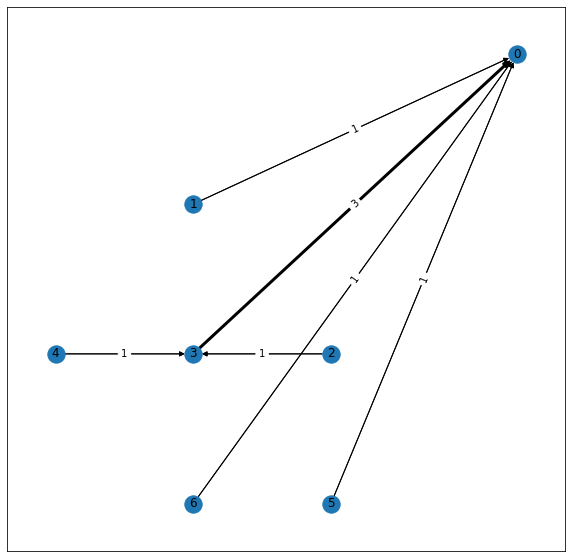

In [165]:
x_prime, best = parse_best(sampleset,x) 

#print(x_prime, s_prime, best)
    
#print("Subtree", N_tree[int(choice)])

final_G = nx.DiGraph()
final_G = nx.from_numpy_array(np.zeros_like(network),create_using=nx.DiGraph(directed=True))

#print(str(final_index // Q))
#print(str(final_index % Q))

for item in x_prime:
    #print(item)
    
    index, level = item
    
    final_G.add_weighted_edges_from([(*edge, level) for edge, label in compelete_label.items() if label == index ])
    


    
matfig = plt.figure(figsize=(10,10)) 
labels = nx.get_edge_attributes(final_G,'weight')
widths = list(nx.get_edge_attributes(final_G,'weight').values())
print("widths",widths)
nx.draw_networkx(final_G, pos)
nx.draw_networkx_edge_labels(final_G,pos,edge_labels = labels)
nx.draw_networkx_edges(final_G,pos,width = widths)

In [67]:
print('qpu_access_time;',sampleset.info['qpu_access_time']*10**(-6), seconds)
print('charge_time:',sampleset.info['charge_time']*10**(-6), seconds)
print('run_time:',sampleset.info['run_time']*10**(-6), seconds)

NameError: name 'seconds' is not defined

In [65]:
bqm, invert = dimod.cqm_to_bqm(cqm)
print(invert)
from dwave.system import LeapHybridSampler
#from dwave.system import DWaveCliqueSampler
#from dwave.system import DWaveSampler, EmbeddingComposite

sampler = LeapHybridSampler()   

#sampler = EmbeddingComposite(DWaveSampler(solver={'qpu': True}))

answer = sampler.sample(bqm)   
print(answer)  

  s_0 s_1 s_2 x_0_1 x_0_2 x_0_3 x_0_4 x_0_5 x_0_6 ... x_9_8 energy num_oc.
0   1   0   0     0     0     0     0     0     0 ...     0  510.0       1
['BINARY', 1 rows, 1 samples, 211 variables]


In [66]:
def parse_best_bqm(sampleset,x,s):
    
    best = sampleset.first
    
    #print(best.sample.items())
    
    s_prime = np.zeros(len(s))
    x_prime = np.zeros(len(x))
    
    s_prime = [(key.replace("s_","")).split('_') for key, val in best.sample.items() if "s_" in key and val]
        
    x_prime = [(key.replace("x_","")).split('_') for key, val in best.sample.items() if "x_" in key and val]

        
    #x_prime = [val for key, val in best.sample.items() if ]
    #result = np.array(x + s)
    #print(x_prime,s_prime)
    
    return  x_prime, s_prime, best

[['0']]
widths ['2', '1', '4', '1', '1', '1', '2', '2', '1']


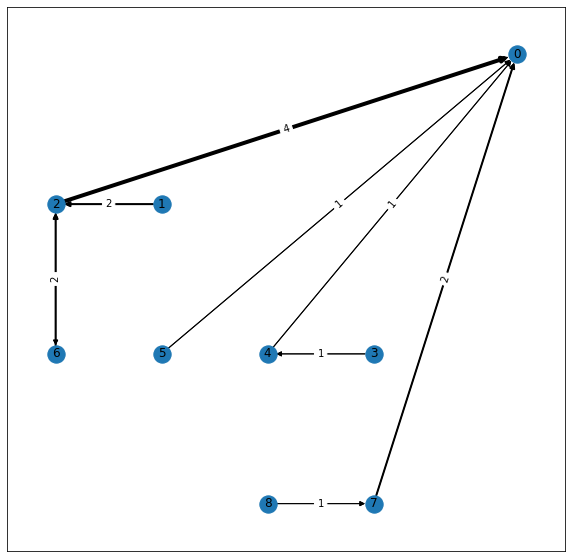

In [67]:
x_prime, s_prime, best = parse_best_bqm(answer,x,s) 

#print(x_prime, s_prime, best)
print(s_prime)
    
#choice = s_prime[0][0]
#choice = s_prime[0][0]
#print(choice, s_prime)

#print("Subtree", N_tree[int(choice)])

final_G = nx.DiGraph()
final_G = nx.from_numpy_array(np.zeros_like(network),create_using=nx.DiGraph(directed=True))

#print(str(final_index // Q))
#print(str(final_index % Q))

for item in x_prime:
    #print(item)
    
    index, level = item
    
    final_G.add_weighted_edges_from([(*edge, level) for edge, label in compelete_label.items() if label == index ])
    


    
matfig = plt.figure(figsize=(10,10)) 
labels = nx.get_edge_attributes(final_G,'weight')
widths = list(nx.get_edge_attributes(final_G,'weight').values())
print("widths",widths)
nx.draw_networkx(final_G, pos)
nx.draw_networkx_edge_labels(final_G,pos,edge_labels = labels)
nx.draw_networkx_edges(final_G,pos,width = widths)

In [68]:
print((cqm.__dict__).keys())
print(list((cqm.__dict__)['_variables']))

dict_keys(['discrete', '_discrete', '_objective', '_variables', '_constraints'])
['s_0', 'x_0_1', 'x_0_2', 'x_0_3', 'x_0_4', 'x_0_5', 'x_0_6', 'x_0_7', 'x_0_8', 'x_1_1', 'x_1_2', 'x_1_3', 'x_1_4', 'x_1_5', 'x_1_6', 'x_1_7', 'x_1_8', 'x_2_1', 'x_2_2', 'x_2_3', 'x_2_4', 'x_2_5', 'x_2_6', 'x_2_7', 'x_2_8', 'x_3_1', 'x_3_2', 'x_3_3', 'x_3_4', 'x_3_5', 'x_3_6', 'x_3_7', 'x_3_8', 'x_4_1', 'x_4_2', 'x_4_3', 'x_4_4', 'x_4_5', 'x_4_6', 'x_4_7', 'x_4_8', 'x_5_1', 'x_5_2', 'x_5_3', 'x_5_4', 'x_5_5', 'x_5_6', 'x_5_7', 'x_5_8', 'x_6_1', 'x_6_2', 'x_6_3', 'x_6_4', 'x_6_5', 'x_6_6', 'x_6_7', 'x_6_8', 'x_7_1', 'x_7_2', 'x_7_3', 'x_7_4', 'x_7_5', 'x_7_6', 'x_7_7', 'x_7_8', 'x_8_1', 'x_8_2', 'x_8_3', 'x_8_4', 'x_8_5', 'x_8_6', 'x_8_7', 'x_8_8', 'x_9_1', 'x_9_2', 'x_9_3', 'x_9_4', 'x_9_5', 'x_9_6', 'x_9_7', 'x_9_8', 'x_10_1', 'x_10_2', 'x_10_3', 'x_10_4', 'x_10_5', 'x_10_6', 'x_10_7', 'x_10_8', 'x_11_1', 'x_11_2', 'x_11_3', 'x_11_4', 'x_11_5', 'x_11_6', 'x_11_7', 'x_11_8', 'x_12_1', 'x_12_2', 'x_12_3', '

In [69]:
print(bqm)
#QUBO = bqm.to_qubo()
QUBO = bqm.to_numpy_matrix(variable_order = list((cqm.__dict__)['_variables']) )
#print(QUBO)
#print(QUBO_1)

BinaryQuadraticModel({'s_0': 2400.0, 'x_0_1': -160.0, 'x_0_2': 0.0, 'x_0_3': 480.0, 'x_0_4': 1280.0, 'x_0_5': 2400.0, 'x_0_6': 3840.0, 'x_0_7': 5600.0, 'x_0_8': 7680.0, 'x_1_1': -160.0, 'x_1_2': 0.0, 'x_1_3': 480.0, 'x_1_4': 1280.0, 'x_1_5': 2400.0, 'x_1_6': 3840.0, 'x_1_7': 5600.0, 'x_1_8': 7680.0, 'x_2_1': -160.0, 'x_2_2': 0.0, 'x_2_3': 480.0, 'x_2_4': 1280.0, 'x_2_5': 2400.0, 'x_2_6': 3840.0, 'x_2_7': 5600.0, 'x_2_8': 7680.0, 'x_3_1': -160.0, 'x_3_2': 0.0, 'x_3_3': 480.0, 'x_3_4': 1280.0, 'x_3_5': 2400.0, 'x_3_6': 3840.0, 'x_3_7': 5600.0, 'x_3_8': 7680.0, 'x_4_1': -160.0, 'x_4_2': 0.0, 'x_4_3': 480.0, 'x_4_4': 1280.0, 'x_4_5': 2400.0, 'x_4_6': 3840.0, 'x_4_7': 5600.0, 'x_4_8': 7680.0, 'x_5_1': -160.0, 'x_5_2': 0.0, 'x_5_3': 480.0, 'x_5_4': 1280.0, 'x_5_5': 2400.0, 'x_5_6': 3840.0, 'x_5_7': 5600.0, 'x_5_8': 7680.0, 'x_6_1': -160.0, 'x_6_2': 0.0, 'x_6_3': 480.0, 'x_6_4': 1280.0, 'x_6_5': 2400.0, 'x_6_6': 3840.0, 'x_6_7': 5600.0, 'x_6_8': 7680.0, 'x_7_1': -160.0, 'x_7_2': 0.0, 'x_7_3':

<ipython-input-69-bd3002179953>:3: DeprecationWarning: bqm.to_numpy_matrix() is deprecated since dimod 0.10.0
  QUBO = bqm.to_numpy_matrix(variable_order = list((cqm.__dict__)['_variables']) )


In [70]:
# Select a solver
from dwave.system import DWaveSampler, EmbeddingComposite
#sampler = LeapHybridSampler()
sampler = EmbeddingComposite(DWaveSampler(solver={'qpu': True}))

sampleset = sampler.sample_qubo(QUBO)

KeyboardInterrupt: 

In [ ]:

sampler = DWaveSampler(solver={'qpu': True})

sampleset = sampler.sample_qubo(QUBO)

In [ ]:
sampler = LeapHybridSampler()
sampleset = sampler.sample_qubo(QUBO)

In [ ]:
final_index, choice = Q_convert(Q, sampleset, edge_number)

print("we choose choice", choice, "which subtree # is", N_tree[choice==1])

final_G = nx.DiGraph()
final_G = nx.from_numpy_array(np.zeros_like(network),create_using=nx.DiGraph(directed=True))

print(str(final_index // Q))
print(str(final_index % Q))

for value in final_index:
    #print(str(value//Q))
    final_G.add_weighted_edges_from([(*edge, value % Q + 1) for edge, label in compelete_label.items() if label == str(value//Q)])
    
matfig = plt.figure(figsize=(10,10)) 
labels = nx.get_edge_attributes(final_G,'weight')
widths = list(nx.get_edge_attributes(final_G,'weight').values())
print("widths",widths)
nx.draw_networkx(final_G, pos)
nx.draw_networkx_edge_labels(final_G,pos,edge_labels = labels)
nx.draw_networkx_edges(final_G,pos,width = widths)